# Part 1B: Sampling, measurement and forward models
Here we are going to do something similar as Part 1A, except we are going to look at a particle instrument.

In [225]:
# IPython magics
%matplotlib inline

In [226]:
# Import packages
import matplotlib
#matplotlib.rc('text', usetex=True)
import matplotlib.pyplot as plt
import matplotlib.image
import seaborn as sb
import numpy as np
import scipy.stats as stats
import scipy.constants as consts
import scipy.ndimage



## Maxwell-Boltzmann distribution
Our first example will be the measurement of 1D particle energy distributions. The canonical Maxwell-Boltzmann distribution
is given by:

\\( f(v) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{mv^2}{2k_BT}\right) \\)

where m is the mass of the species, n is the (number) density, k<sub>B</sub>T is the temperature, and v is the speed at which we are looking for the distribution function. Here we will use a "drifting Maxwellian" which is a Maxwell-Boltzmann distribution that is moving at a relative velocity to the frame of the distribution.

\\( f(\mathbf{v}) = n \left(\frac{m}{2\pi k_BT}\right)^{3/2} \exp \left(-\frac{m(\mathbf{v_0}-\mathbf{v})^2}{2k_BT}\right) \\)

We also need to convert the distribution function to units of differential number flux, also known as DNF [m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>], and differential energy flux, also known as DEF [J m<sup>-2</sup> s<sup>-1</sup> sr<sup>-1</sup> J<sup>-1</sup>]. Note that the "J/J" part of the DEF units is retained to indicate DEF and to avoid ambiguity.

\\( J_N = f\frac{v^2}{m} \\)  
\\( J_E = f\frac{v^4}{2m} \\)

In our code we will implement the drifting Maxwellian and conversions as a Python lambda functions.

In [227]:
# Distribution function for a drifting isotropic Maxwell-Boltzmann distribution with density n [m^-3], temperature kT [eV],
# velocity v0 [km/s], direction of flow (th0,ph0) [deg], for a species of mass m [u], charge state q [dimensionless integer],
# at energies per charge EperQ [eV/q], look direction (th,ph) [deg]. Returns the value of the distribution function
# in units of s^3/m^6 at the velocity (vx,vy,vz) [m/s] - note the different units for velocity.
def dist_mb(m, q, n, v0, th0, ph0, kT, EperQ, th, ph):
    v0x = v0*1e3*np.cos(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0y = v0*1e3*np.sin(ph0*np.pi/180.0)*np.sin(th0*np.pi/180.0)
    v0z = v0*1e3*np.cos(th0*np.pi/180.0)
    v = np.sqrt(2.0*q*EperQ*consts.e/(m*consts.u))
    vx = v*np.cos(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vy = v*np.sin(ph*np.pi/180.0)*np.sin(th*np.pi/180.0)
    vz = v*np.cos(th*np.pi/180.0)
    x = 0.5*m*consts.u*v0*v0*1e6 + EperQ*consts.e*q - m*consts.u*(v0x*vx + v0y*vy + v0z*vz)
#x = 0.5*m*consts.u*((v0x-vx)**2 + (v0y-vy)**2 + (v0z-vz)**2)
    return n*((m*consts.u/(2*np.pi*kT*consts.e))**(1.5))*np.exp(-x/(kT*consts.e))

# Functions to convert from distribution function to flux units (both differential energy flux and differential number flux)
# f in units of s^3 m^-6, EperQ in units of eV/q, m in units of u, and q is an integer
todnf = lambda f, EperQ, m, q: f*EperQ*consts.e*2*(q/(m*consts.u))**2
todef = lambda f, EperQ, m, q: f*((EperQ*consts.e)**2)*q*2*(q/(m*consts.u))**2

To start, let's plot out the distribution function (as a function of energy) for a 100 eV Maxwell-Boltzmann distribution of electrons moving at zero relative speed. When plotted as log-lin graph we get a straight line (as a consequence of the exponential in the Maxwell-Boltzmann distribution function.

In [228]:
# E is a high resolution energy table, f is then the calculated Maxwellian.
E = np.logspace(0,4,400) # in eV/q
f = dist_mb(consts.electron_mass/consts.u, 1.0, 1e6, 0.0,0.0,0.0, 100.0, E,0.0,0.0)

Text(0,0.5,'Distribution function [s$^3$ m$^{-6}$]')

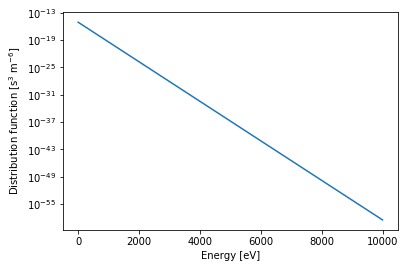

In [229]:
plt.semilogy(E,f)
plt.xlabel('Energy [eV]')
plt.ylabel('Distribution function [s$^3$ m$^{-6}$]')

Let's now plot this in units of differential energy flux. This is now in "calibrated physical units" similar to what might be provided in a data archive. You should be able to see that the peak of the curve lies at 200 eV; this is an exact result for a Maxwell-Boltzmann distribution when plotted in units of DEF, the peak of the curve is at twice the temperature.

Text(0,0.5,'Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')

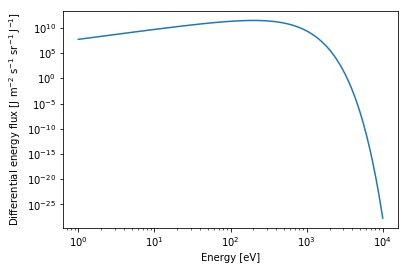

In [230]:
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0))
plt.xlabel('Energy [eV]')
plt.ylabel('Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')

We have one final conversion to get this into units that an instrument might measure. These use the **geometric factor** (G) for the sensor, which accounts for how much of this particle flux ends up reaching the detector, and an **efficiency factor** (\\(\epsilon\\)) for the sensor. In reality both of these quantities might vary with energy but for now we just use an efficiency that varies with energy (using a simple expression) and 10<sup>8</sup> m<sup>2</sup> sr for the geometric factor. The count rate (R) in units of counts/s or Hz is:

\\( R = F_E G\epsilon \\)

This is the count rate that an instrument will be exposed to, but instruments count for a finite duration of time, the **accumulation time** \\(\tau_a\\), which needs to be included to get the mean of the Poisson distribution.

The count (the counts/accumulation, $C$) distribution in a given pixel can be described as a Poisson distribution with a mean \\(F_E G\epsilon\tau_a\\):

\\( C = R\tau_a \\)


In [231]:
G = 1e-8
quantumeff = lambda E, scale=10000: np.exp(-(E/10000)**2)
eps = quantumeff(E)
taua = 0.1

Text(0,0.5,'Count rate [Hz]')

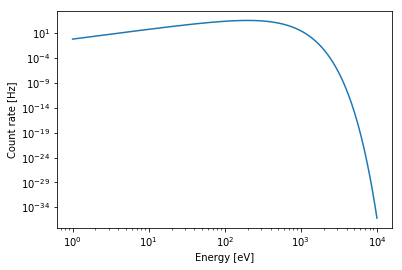

In [232]:
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps)
plt.xlabel('Energy [eV]')
plt.ylabel('Count rate [Hz]')

As one can see, to measure significant counts above several keV the instrument must measure for a very very long time (years) in order to even accumulate a single count. Let's look at this in units of counts per accumulation.

(0.01, 1000.0)

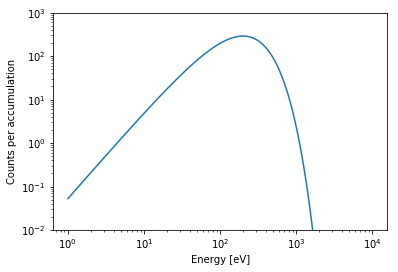

In [233]:
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps*taua)
plt.xlabel('Energy [eV]')
plt.ylabel('Counts per accumulation')
plt.ylim([1e-2,1e3])

All the counts above about a keV will be near zero. The counts per accumulation for each bin is a random variable described by a Poisson distribution. Let's sample from those Poisson distributions to get a simulated spectrum.

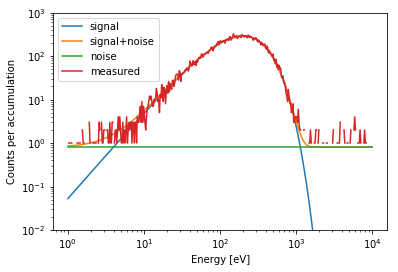

In [234]:
# Sampling - here we add noise at a level of 0.8 counts/accumulation. We could include
# the noise level in counts/s, but we need to write as taua*noise in the sampling.
noise = 0.8
C = np.random.poisson(todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps*taua + noise)

# Plot the resulting distribution along with the real distribution for comparison.
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps*taua, label='signal')
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps*taua + noise, label='signal+noise')
plt.loglog(E, np.zeros(E.shape)+noise, label='noise')
plt.loglog(E,C, label='measured')
plt.xlabel('Energy [eV]')
plt.ylabel('Counts per accumulation')
plt.ylim([1e-2,1e3])
plt.legend()

## Compression
Now let's experiment with quasi-log compression. The following functions implement the compression and decompression algorithm. We use the same compression algorithm as in the lectures.

C:\Users\arridge\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide
C:\Users\arridge\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


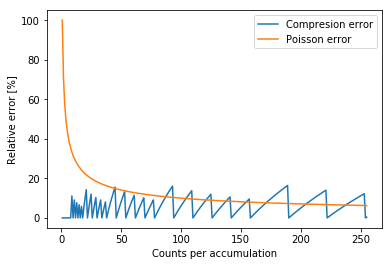

In [235]:
def quasilogcompression(x):
    steps = [0,1,2,3,4,5,6,7,8,10,12,14,16,18,22,26,30,34,38,46,54,62,70,78,94,110,126,142,158,190,222,254,256]
    z = x*0;
    for i in range(32):
        z[(x>=steps[i])*(x<steps[i+1])] = i
    z[(x>steps[i+1])]=31
    return z

def quasilogdecompression(x):
    steps = [0,1,2,3,4,5,6,7,8,10,12,14,16,18,22,26,30,34,38,46,54,62,70,78,94,110,126,142,158,190,222,254,256]
    z = x*0;
    for i in range(32):
        z[(x==i)]=steps[i]
    return z

# Plot the Poisson uncertainty (square root of the counts) and the error due to the compression.
x = np.arange(0,256,1)
plt.plot(x,(x-quasilogdecompression(quasilogcompression(x)))*100/x, label='Compresion error')
plt.plot(x,np.sqrt(x)*100/x, label='Poisson error')
plt.xlabel('Counts per accumulation')
plt.ylabel('Relative error [%]')
plt.legend()

## Apply to our sampled spectrum

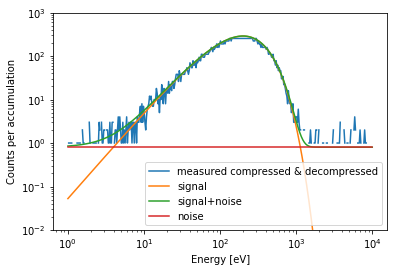

In [236]:
plt.loglog(E,quasilogdecompression(quasilogcompression(C)),label='measured compressed & decompressed')
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps*taua, label='signal')
plt.loglog(E, todef(f,E,consts.electron_mass/consts.u,1.0)*G*eps*taua + noise, label='signal+noise')
plt.loglog(E, np.zeros(E.shape)+noise, label='noise')
plt.xlabel('Energy [eV]')
plt.ylabel('Counts per accumulation')
plt.ylim([1e-2,1e3])
plt.legend()

## Observations
1. One can see the Poisson noise below 10 ev and above 1 keV.
2. The flat top to the distribution is because the counts are represented by 8 bits and we have "run out" of dynamic range.

## Inverting to get the electron properties back.
We now want to work backwards to get the electron parameters from the data. Firstly, we use a more realistic number of energy bins (50). We need to estimate the noise, remove it, understand the signal-to-noise (S/N) ratio, filter out pixels with avery low S/N.

Let's generate the foreground, add in the noise and then sample.

In [237]:
# High resolution version of the foreground signal (for comparison).
E_hi = np.logspace(0,4,400) # in eV/q
f_hi = dist_mb(consts.electron_mass/consts.u, 1.0, 1e6, 0.0,0.0,0.0, 100.0, E_hi,0.0,0.0)

# Generate the sample (n=1e6 m^-3, kT=100 eV, noise level=50.8 counts/accumulation)
E = np.logspace(0,4,50) # in eV/q
f = dist_mb(consts.electron_mass/consts.u, 1.0, 1e6, 0.0,0.0,0.0, 100.0, E,0.0,0.0)
C = np.random.poisson(todef(f,E,consts.electron_mass/consts.u,1.0)*G*quantumeff(E)*taua + 50.8)
data = quasilogdecompression(quasilogcompression(C)).astype(np.float)

Firstly, let's assess the noise level. There are two methods - we could estimate from the data - in a region of the spectrum we are **sure** has no real signal. Or we could use some sort of model - let's assume that we think the noise level is 0.5 counts/accumulation. We also include compression noise as 10% of the data and the Poisson noise.

Text(0,0.5,'Counts per accumulation')

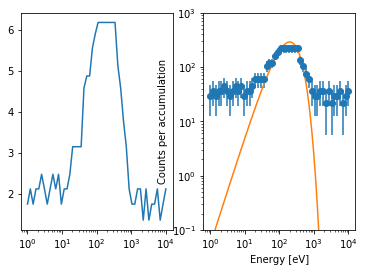

In [238]:
# Estimate the noise as 10 counts/accumulation but noise also appears as the uncertainty
# from the Poisson counting statistics. Signal-to-noise ratio is signal/noise.
noise = 10 + np.maximum(np.sqrt(data), 0.1*data)#np.sqrt(10**2 + np.maximum(np.sqrt(data), 0.1*data)**2)
signal = data - noise
snr = signal/noise
snr_limit = 1.0

# Plot S/N ratio and counts.
plt.subplot(1,2,1)
plt.semilogx(E, snr)
plt.subplot(1,2,2)
plt.errorbar(E[snr>snr_limit],signal[snr>snr_limit],yerr=noise[snr>snr_limit],fmt='o')
plt.loglog(E_hi,todef(f_hi,E_hi,consts.electron_mass/consts.u,1.0)*G*quantumeff(E_hi)*taua)
plt.ylim([1e-1,1e3])
plt.xlabel('Energy [eV]')
plt.ylabel('Counts per accumulation')


Now we have a spectrum that we hope is just signal, we can convert to calibrated units using the calibration G, eff and accumulation time.

(100000000.0, 1000000000000.0)

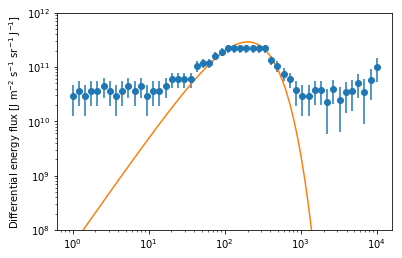

In [239]:
signal_def = signal/(G*quantumeff(E)*taua)
plt.errorbar(E[snr>snr_limit],signal_def[snr>snr_limit],yerr=signal_def[snr>snr_limit]*noise[snr>snr_limit]/signal[snr>snr_limit],fmt='o')
plt.loglog(E_hi,todef(f_hi,E_hi,consts.electron_mass/consts.u,1.0))
plt.ylabel('Differential energy flux [J m$^{-2}$ s$^{-1}$ sr$^{-1}$ J$^{-1}$]')
plt.ylim([1e8,1e12])

## Non-linear fitting to recover the properties of the electrons
So now we have a clean spectrum we can try to fit a Maxwellian to the flux and recover the source parameters.

In [240]:
# This is our forward model. It simply returns a spectrum in units of counts/accumulation for a given density and temperature
fitfun = lambda xdata, n, kT: todef(dist_mb(consts.electron_mass/consts.u, 1.0, np.exp(n), 0.0,0.0,0.0, kT, xdata,0.0,0.0),xdata,consts.electron_mass/consts.u,1.0)

# Non-linear fit- basic. Using iterative algorithm that needs initial guesses (p0). Note that we fit the density in the
# log of the density. This is because the algorithm will take numerical derivatives and if the density was 10^5 and the
# temperature was 80 then you might get big numerical errors.
p0 = [5.0, 80.0]
data_err = signal_def*noise/signal
p, pcov = scipy.optimize.curve_fit(fitfun, E[snr>snr_limit], signal_def[snr>snr_limit], p0, sigma=data_err)

# Propagate the uncertainty on the density - need to do more work on that since we fit for the log(n).
n_err = np.sqrt(pcov[0,0]*np.exp(2*p[0]))
T_err = np.sqrt(pcov[1,1])

print('Density: {} +- {} [{}%]'.format(np.exp(p[0]), n_err, n_err*100/np.exp(p[0])))
print('Temperature: {} +- {} [{}%]'.format(p[1],T_err, T_err*100/p[1]))
print(pcov)

# Formally, we should really significance test the chi^2 to make sure the fit is significant.

Density: 979274.6016064583 +- 82036.81009834395 [8.377303972120389%]
Temperature: 97.16884295961307 +- 6.182944628441854 [6.3630938067377345%]
[[  7.01792218e-03  -1.99812572e-01]
 [ -1.99812572e-01   3.82288043e+01]]


# Finally we can look at the \chi^2 space (n,T) of the fit.
Notice how the minimum is fairly broad in temperature and that there is a sharp cut off in density (due to the limited dynamic range).

Text(0,0.5,'T [eV]')

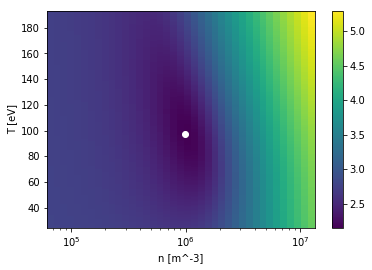

In [258]:
nx = np.arange(0.8,1.2,0.01)
Tx = np.arange(0.25,2,0.01)
chi2 = np.zeros((len(nx),len(Tx)))
for i in range(len(nx)):
    for j in range(len(Tx)):
        chi2[i,j] = np.log10(np.sum(((signal_def[snr>snr_limit] - fitfun(E[snr>snr_limit],nx[i]*p[0],Tx[j]*p[1]))/data_err[snr>snr_limit])**2))
plt.pcolor(np.exp(nx*p[0]),Tx*p[1],chi2.T)
plt.plot([np.exp(p[0])],[p[1]],'ow')
plt.colorbar()
plt.xscale('log')
plt.xlabel('n [m^-3]')
plt.ylabel('T [eV]')